In [1]:
import numpy as np, pandas as pd
import sympy as sym
from sympy import symbols, Matrix, solve, simplify

In [2]:
from db_queries import get_outputs as go, get_ids
from vivarium import Artifact

## INITIALIZE VARS

In [3]:
## SOLVE EQNS
s4, i3 = symbols('s4 i3')
r4, s3, i2 = symbols('r4 s3 i2')
r3, s2, i1 = symbols('r3 s2 i1')
r2, s1 = symbols('r2 s1')
d4, d3, d2, d1, sld, dother = symbols('d4 d3 d2 d1 sld dother')
f4, f3, f2, f1 = symbols('f4 f3 f2 f1')

p4, p3, p2, p1, p0 = symbols('p4 p3 p2 p1 p0')

acmr = sym.Symbol('acmr')

dur_cat1, dur_cat2, dur_cat3, dur_cat4 = symbols('dur_cat1 dur_cat2 dur_cat3 dur_cat4')

In [4]:
unknowns = [s1,s2,s3,s4,r2,r3,r4,i1,i2,i3,d1,d2,d3,d4,f1,f2,f3,f4]

def add_eq(terms, y, i, A, v):
    """
    For input equation y = sum([coeff*var for var:coeff in {terms}])
    adds right side of equation to to row i of matrix A

    adds y to row i of vector v
    """
    for x in terms.keys():
        A[x][i] = terms[x]
    v.iloc[i] = y


def build_matrix(eqns, unknowns):
    """
    INPUT
    ----
    eqns: a list of sympy equations
    unknowns: a list of sympy unknowns
    ----
    OUTPUT
    ----
    A:  a matrix containing the coefficients of LHS of all eq in eqns.
      nrows = number of equations
      rcols = number of unknowns
    b: an nx1 matrix containing the RHS of all the eqns
    x: a sympy matrix of the unknowns
    """
    n_eqns = len(eqns)
    n_unknowns = len(unknowns)

    # frame for matrix/LHS equations.
    # nrows = n_eqns, ncols = n_unknowns
    A = pd.DataFrame(
        index = range(n_eqns),
        columns = unknowns,
        data = np.zeros([n_eqns,n_unknowns])
    )

    # frame for RHS of equations
    b = pd.DataFrame(index = range(n_eqns), columns = ['val'])

    # populate LHS/RHS
    i = 0
    for eq in eqns:

        add_eq(eq[0], eq[1], i, A, b)
        i += 1

    # convert to sympy matrices
    A = sym.Matrix(A)
    b = sym.Matrix(b)
    x = sym.Matrix(unknowns) #vars to solve for

    return A, x, b

## SETTINGS

In [5]:
age_group = 4 #post neonatal
sex = 2 #female


# duration_mam = 70 #days
# duration_sam = 40 #days
# i3_options = [1/3,1/3-.01,
#               1/3-.001,
#               1/3-.00001,
#               1/4,
#               1/6,
#               1/10,
#               1/100,
#               1/300]

## RUN SCRIPTS

In [6]:
# RUN SCRIPTS
from set_background_vals import *

d1_val, d2_val, d3_val, d4_val = [1-np.exp(-1*i/365) for i in set_ds(sex_id = sex, age_group_id = age_group)]
f1_val, f2_val, f3_val, f4_val = set_fs(sex_id = sex, age_group_id = age_group)

## TODO: is this the correct time_step?
p0_val, p1_val, p2_val, p3_val, p4_val = set_ps(sex_id = sex, age_group_id = age_group, time_step = 1)

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/ihme/homes/beatrixh/vivarium_research_ciff/wasting_transitions/set_background_vals.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasting_exp['sex_id'] = np.where(wasting_exp['sex'] == 'Male', 1, 2)
/ihme/homes/beatrixh/vivarium_research_ciff/wasting_transitions/set_background_vals.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

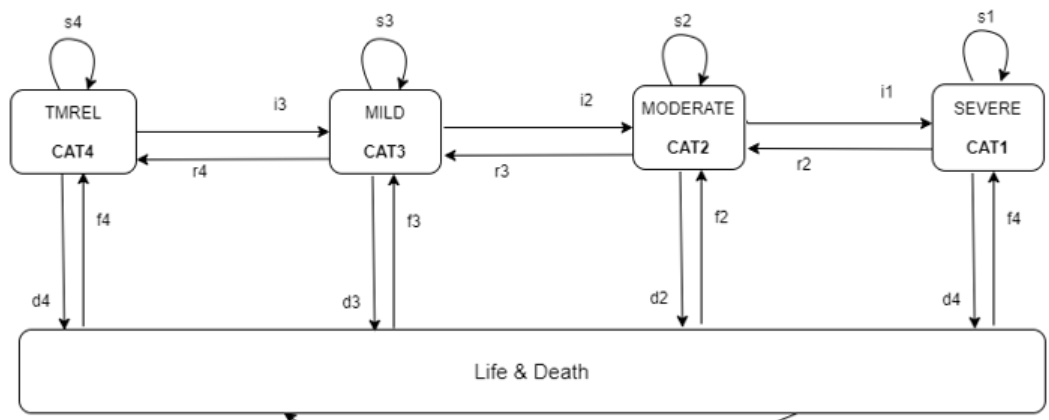

In [7]:
# # assuming equilibrium:
# p4*s4 + p3*r4 + p0*f4 = p4
eq1 = [{s4:p4, r4:p3, f4:p0}, p4]

# p4*i3 + p3*s3 + p2*r3 + p0*f3 = p3
eq2 = [{i3:p4, s3:p3, r3:p2, f3:p0}, p3]

# p3*i2 + p2*s2 + p1*r2 + p0*f2 = p2
eq3 = [{i2:p3, s2:p2, r2:p1, f2:p0}, p2]

# p2*i1 + p1*s1 + p0*f1 = p1
eq4 = [{i1:p2, s1:p1, f1:p0}, p1]

# p4*d4 + p3*d3 + p2*d2 + p1*d1 + p0*sld = p0
eq5 = [{d4:p4, d3:p3, d2:p2, d1:p1}, p0]


# # rows sum to one:
# s4 + i3 + d4 = 1
eq6 = [{s4:1, i3:1, d4:1}, 1]

# r4 + s3 + i2 + d3 = 1
eq7 = [{r4:1, s3:1, i2:1, d3:1}, 1]

# r3 + s2 + i1 + d2 = 1
eq8 = [{r3:1, s2:1, i1:1, d2:1}, 1]

# r2 + s1 + d1 = 1
eq9 = [{r2:1, s1:1, d1:1}, 1]

# f4 + f3 + f2 + f1 + sld = 1
eq10 = [{f4:1, f3:1, f2:1, f1:1}, 1]

# # adding durations of states
# r2 + d1 = 1/Dsam = 1/40
eq11 = [{r2:1, d1:1}, (1/dur_cat1)]

# r3 + i1 + d2 = 1/Dmam = 1/70
eq12 = [{r3:1, i1:1, d2:1}, (1/dur_cat2)]

# r4 + i2 + d3 = 1/Dmild
eq13 = [{r4:1, i2:1, d3:1}, 1/dur_cat3]

# i3 + d4 = 1/Dtmrel
eq14 = [{i3:1, d4:1}, 1/dur_cat4]

In [8]:
# A1, x1, b1 = build_matrix([eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12],
#                        unknowns)
# result = sym.solve(A1 * x1 - b1, x1)

all_eqns = [eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12,eq13]#,eq11,eq12,eq13,eq14]
A1, x1, b1 = build_matrix(all_eqns,
                       unknowns)
result = sym.solve(A1 * x1 - b1, x1)

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## CHECKOUT WHAT WE WERE SOLVING

In [9]:
len(all_eqns)

13

In [10]:
# matrix we're solving
pd.DataFrame(np.array(A1), columns = unknowns, index = [f'eq{i}' for i in range(1,len(all_eqns)+1)])

,s1,s2,s3,s4,r2,r3,r4,i1,i2,i3,d1,d2,d3,d4,f1,f2,f3,f4
eq1,0.0,0.0,0.0,p4,0.0,0.0,p3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p0
eq2,0.0,0.0,p3,0.0,0.0,p2,0.0,0.0,0.0,p4,0.0,0.0,0.0,0.0,0.0,0.0,p0,0.0
eq3,0.0,p2,0.0,0.0,p1,0.0,0.0,0.0,p3,0.0,0.0,0.0,0.0,0.0,0.0,p0,0.0,0.0
eq4,p1,0.0,0.0,0.0,0.0,0.0,0.0,p2,0.0,0.0,0.0,0.0,0.0,0.0,p0,0.0,0.0,0.0
eq5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p1,p2,p3,p4,0.0,0.0,0.0,0.0
eq6,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
eq7,0.0,0.0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
eq8,0.0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
eq9,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eq10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1


In [11]:
# equals
np.array(x1)

array([[s1],
       [s2],
       [s3],
       [s4],
       [r2],
       [r3],
       [r4],
       [i1],
       [i2],
       [i3],
       [d1],
       [d2],
       [d3],
       [d4],
       [f1],
       [f2],
       [f3],
       [f4]], dtype=object)

In [12]:
# solution to our system of eqns
result

{s1: (dur_cat1 - 1)/dur_cat1,
 s2: (dur_cat2 - 1)/dur_cat2,
 s3: (dur_cat3 - 1)/dur_cat3,
 s4: -d2*p2/p4 - d4 - f2*p0/p4 - f4*p0/p4 + (dur_cat1*dur_cat2*dur_cat3*p0 + dur_cat1*dur_cat2*dur_cat3*p4 - dur_cat1*dur_cat2*p3 + dur_cat1*dur_cat3*p2 - dur_cat2*dur_cat3*p1)/(dur_cat1*dur_cat2*dur_cat3*p4),
 r2: d2*p2/p1 + d3*p3/p1 + d4*p4/p1 + (-dur_cat1*p0 + p1)/(dur_cat1*p1),
 r3: -d2 - f2*p0/p2 - f3*p0/p2 - f4*p0/p2 + (dur_cat1*dur_cat2*p0 + dur_cat1*p2 - dur_cat2*p1)/(dur_cat1*dur_cat2*p2),
 r4: d2*p2/p3 + d4*p4/p3 + f2*p0/p3 + (-dur_cat1*dur_cat2*dur_cat3*p0 + dur_cat1*dur_cat2*p3 - dur_cat1*dur_cat3*p2 + dur_cat2*dur_cat3*p1)/(dur_cat1*dur_cat2*dur_cat3*p3),
 i1: f2*p0/p2 + f3*p0/p2 + f4*p0/p2 + (-dur_cat1*p0 + p1)/(dur_cat1*p2),
 i2: -d2*p2/p3 - d3 - d4*p4/p3 - f2*p0/p3 + (dur_cat1*dur_cat2*p0 + dur_cat1*p2 - dur_cat2*p1)/(dur_cat1*dur_cat2*p3),
 i3: d2*p2/p4 + f2*p0/p4 + f4*p0/p4 + (-dur_cat1*dur_cat2*dur_cat3*p0 + dur_cat1*dur_cat2*p3 - dur_cat1*dur_cat3*p2 + dur_cat2*dur_cat3*p1)/(du

In [13]:
subs = {
    s1: s1,
    s2: s2,
    s3: s3,
    s4: s4,
    r2: r2,
    r3: r3,
    r4: r4,
    i1: i1,
    i2: i2,
    i3: i3,
    d1: d1_val,
    d2: d2_val,
    d3: d3_val,
    d4: d4_val,
    f1: f1_val,
    f2: f2_val,
    f3: f3_val,
    f4: f4_val,
    p0: p0_val,
    p1: p1_val,
    p2: p2_val,
    p3: p4_val,
    p4: p4_val
}

In [14]:
def solution_set(dur_1, dur_2, dur_3):
    duration_subs = {dur_cat1:dur_1, dur_cat2:dur_2, dur_cat3:dur_3}
    df = pd.DataFrame({
        'var':result.keys(),
        'val':[result[i].subs(subs).subs(duration_subs) for i in result.keys()]
    })
    print(df)# df

solution_set(40, 70, 365)

   var                   val
0   s1                 39/40
1   s2                 69/70
2   s3               364/365
3   s4     0.997645467029362
4   r2    0.0247501157160120
5   r3   0.00212793795979299
6   r4   0.00231972944348034
7   i1    0.0121196250897494
8   i2  0.000403025094798306
9   i3   0.00234450821331160
10  d1  0.000249884283987994
11  f1    0.0546405338490388


In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [16]:
y = interactive(solution_set, dur_1 = 40, dur_2 = 70, dur_3 = 365)

In [17]:
display(y)

interactive(children=(IntSlider(value=40, description='dur_1', max=120, min=-40), IntSlider(value=70, descript…